In [21]:
pip install imageio

Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install --upgrade mxnet

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install torch==1.7.1+cpu torchvision==0.8.2+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install --upgrade gluoncv

Note: you may need to restart the kernel to use updated packages.


In [25]:
pip install "opencv-python-headless<4.3"

Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np
import cv2
import mxnet as mx
from mxnet.gluon.data.vision import transforms
import gluoncv
import imageio as iio
# using cpu
ctx = mx.cpu(0)

In [27]:
url = 'https://raw.githubusercontent.com/KuangHaofei/GluonCV_Test/master/monodepthv2/tutorials/test_img.png'
filename = 'test_img.png'
gluoncv.utils.download(url, filename, True)

729KB [00:00, 6601.51KB/s]                         


'test_img.png'

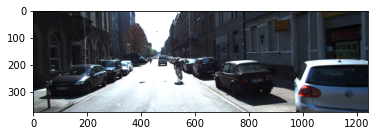

In [28]:
import PIL.Image as pil
img = pil.open(filename).convert('RGB')

from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

In [29]:
original_width, original_height = img.size
feed_height = 192
feed_width = 640

img = img.resize((feed_width, feed_height), pil.LANCZOS)
img = transforms.ToTensor()(mx.nd.array(img)).expand_dims(0).as_in_context(context=ctx)

/tmp/ipykernel_153/3791877393.py:5: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((feed_width, feed_height), pil.LANCZOS)


In [30]:
model = gluoncv.model_zoo.get_model('monodepth2_resnet18_kitti_stereo_640x192',
                                    pretrained_base=False, ctx=ctx, pretrained=True)

In [31]:
outputs = model.predict(img)
disp = outputs[("disp", 0)]
disp_resized = mx.nd.contrib.BilinearResize2D(disp, height=original_height, width=original_width)

In [32]:
import matplotlib as mpl
import matplotlib.cm as cm

In [33]:
disp_resized_np = disp_resized.squeeze().as_in_context(mx.cpu()).asnumpy()
# here the original depth is presented in mm 
# so 1000 should be a proper way to do
disp_resized_np= np.array(disp_resized_np*1000, dtype=np.uint8)

In [34]:
disp_resized_np

array([[  4,   3,   2, ...,  71,  71,  71],
       [  4,   3,   2, ...,  71,  71,  71],
       [  4,   3,   2, ...,  71,  71,  71],
       ...,
       [  6,   4,   2, ..., 164, 164, 164],
       [  6,   4,   2, ..., 164, 164, 164],
       [  6,   4,   2, ..., 164, 164, 164]], dtype=uint8)

In [35]:
 iio.imwrite('../Project-demo/sample_data/depth_predict.png', disp_resized_np)

In [36]:
def compute_pcd_vectorization(depth_im):
    """
    This function use victorization operations to optimize time.
    We can do better by computing constants first.
    Please see the main function.
    :param depth_im: a depth image
    :return: the computed point cloud
    """
    # get depth resolution:
    height, width = depth_im.shape
    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)
    # rechape depth image
    z = depth_im.reshape(height * width)
    # compute pcd:
    pcd = np.dstack([(ii - CX_DEPTH) * z / FX_DEPTH,
                    (jj - CY_DEPTH) * z / FY_DEPTH,
                    z]).reshape((length, 3))
    return pcd

Image resolution: (375, 1242)
Data type: uint8
Min value: 0
Max value: 164


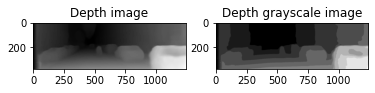

In [37]:
if __name__ == '__main__':
    # Camera parameters:
    FX_DEPTH = 5.8262448167737955e+02
    FY_DEPTH = 5.8269103270988637e+02
    CX_DEPTH = 3.1304475870804731e+02
    CY_DEPTH = 2.3844389626620386e+02

    # Read depth image:
    # ../data/depth.png
    depth_image = iio.imread('../Project-demo/sample_data/depth_predict.png')

    # print some properties:
    print(f"Image resolution: {depth_image.shape}")
    print(f"Data type: {depth_image.dtype}")
    print(f"Min value: {np.min(depth_image)}")
    print(f"Max value: {np.max(depth_image)}")

    # Compute depth grayscale:
    depth_grayscale = np.array(256 * depth_image / 0x0fff, dtype=np.uint8)
    iio.imwrite('../Project-demo/sample_data/depth_gray_scale.png', depth_grayscale)

    # Display depth and grayscale image:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(depth_image, cmap="gray")
    axs[0].set_title('Depth image')
    axs[1].imshow(depth_grayscale, cmap="gray")
    axs[1].set_title('Depth grayscale image')
    plt.show()

    # get depth image resolution:
    height, width = depth_image.shape
    
    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)
    # Compute constants:
    xx = (jj - CX_DEPTH) / FX_DEPTH
    yy = (ii - CY_DEPTH) / FY_DEPTH
    # transform depth image to vector of z:
    length = height * width
    
    z = depth_image.reshape(length)
    
    # compute point cloud
    pcd = np.dstack((xx * z, yy * z, z)).reshape((length, 3))

    ## Convert to Open3D.PointCLoud:
    #pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
   # pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
    ## Visualize:
    #o3d.visualization.draw_geometries([pcd_o3d])

In [38]:
pcd.shape

(465750, 3)

In [39]:
pcd

array([[ -2.14920429,  -1.63684617,   4.        ],
       [ -1.6067541 ,  -1.22763463,   3.        ],
       [ -1.06773666,  -0.81842308,   2.        ],
       ...,
       [260.64242809,  38.15263967, 164.        ],
       [260.92391301,  38.15263967, 164.        ],
       [261.20539792,  38.15263967, 164.        ]])

In [40]:
with open('../Project-demo/sample_data/test.npy', 'wb') as f:
    np.save(f, pcd)


In [41]:
with open('../Project-demo/sample_data/test.npy', 'rb') as f:
    a = np.load(f)
print(a)

[[ -2.14920429  -1.63684617   4.        ]
 [ -1.6067541   -1.22763463   3.        ]
 [ -1.06773666  -0.81842308   2.        ]
 ...
 [260.64242809  38.15263967 164.        ]
 [260.92391301  38.15263967 164.        ]
 [261.20539792  38.15263967 164.        ]]


In [42]:
def compute_colored_pointcloud_nested_loops(depth_image, rgb_image):
    """
    Compute the colored point cloud using nested loops.
    This function is written for demonstration purposes.
    It takes time.
    :param depth_image: a depth image
    :param rgb_image: the corresponding rgb image
    :return: the colored point cloud
    """

    height, width = depth_image.shape
    colors = []
    pcd = []
    for i in range(height):
        for j in range(width):
            """
                Convert the pixel from depth coordinate system
                to depth sensor 3D coordinate system
            """
            z = depth_image[i][j]
            x = (j - CX_DEPTH) * z / FX_DEPTH
            y = (i - CY_DEPTH) * z / FY_DEPTH

            """
                Convert the point from depth sensor 3D coordinate system
                to rgb camera coordinate system:            
            """
            [x_RGB, y_RGB, z_RGB] = np.linalg.inv(R).dot([x, y, z]) - np.linalg.inv(R).dot(T)

            """
                Convert from rgb camera coordinate system
                to rgb image coordinate system:            
            """
            j_rgb = int((x_RGB * FX_RGB) / z_RGB + CX_RGB + width / 2)
            i_rgb = int((y_RGB * FY_RGB) / z_RGB + CY_RGB)

            # Add point to point cloud:
            pcd.append([x, y, z])

            # Add the color of the pixel if it exists:
            if 0 <= j_rgb < width and 0 <= i_rgb < height:
                colors.append(rgb_image[i_rgb][j_rgb])
            else:
                colors.append([0., 0., 0.])
    return [np.array(pcd), np.array(colors)]

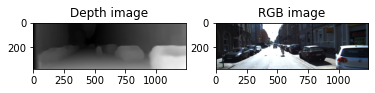

In [43]:
if __name__ == '__main__':
    # Depth Camera parameters:
    FX_DEPTH = 5.8262448167737955e+02
    FY_DEPTH = 5.8269103270988637e+02
    CX_DEPTH = 3.1304475870804731e+02
    CY_DEPTH = 2.3844389626620386e+02

    # RGB camera intrinsic Parameters:
    FX_RGB = 5.1885790117450188e+02
    FY_RGB = 5.1946961112127485e+02
    CX_RGB = 3.2558244941119034e+0
    CY_RGB = 2.5373616633400465e+02

    # Rotation matrix:
    R = -np.array([[9.9997798940829263e-01, 5.0518419386157446e-03, 4.3011152014118693e-03],
                   [-5.0359919480810989e-03, 9.9998051861143999e-01, -3.6879781309514218e-03],
                   [- 4.3196624923060242e-03, 3.6662365748484798e-03, 9.9998394948385538e-01]])
    # Translation vector:
    T = np.array([2.5031875059141302e-02, -2.9342312935846411e-04, 6.6238747008330102e-04])

    # Read depth and color image:
    depth_image = iio.imread('../Project-demo/sample_data/depth_predict.png')
    rgb_image = iio.imread('../Project-demo/sample_data/test_img.png')

    # Display depth and grayscale image:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(depth_image, cmap="gray")
    axs[0].set_title('Depth image')
    axs[1].imshow(rgb_image)
    axs[1].set_title('RGB image')
    plt.show()

    # compute point cloud:
    # Both images has the same resolution
    height, width = depth_image.shape

    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)

    # Compute constants:
    xx = (jj - CX_DEPTH) / FX_DEPTH
    yy = (ii - CY_DEPTH) / FY_DEPTH

    # transform depth image to vector of z:
    length = height * width
    z = depth_image.reshape(length)

    # compute point cloud
    pcd = np.dstack((xx * z, yy * z, z)).reshape((length, 3))
    cam_RGB = np.apply_along_axis(np.linalg.inv(R).dot, 1, pcd) - np.linalg.inv(R).dot(T)
    xx_rgb = ((cam_RGB[:, 0] * FX_RGB) / cam_RGB[:, 2] + CX_RGB + width / 2).astype(int).clip(0, width - 1)
    yy_rgb = ((cam_RGB[:, 1] * FY_RGB) / cam_RGB[:, 2] + CY_RGB).astype(int).clip(0, height - 1)
    colors = rgb_image[yy_rgb, xx_rgb]



In [44]:
with open('../Project-demo/sample_data/test_2_pcd.npy', 'wb') as f:
    np.save(f, pcd)

with open('../Project-demo/sample_data/test_2_colors.npy', 'wb') as f:
    np.save(f, colors)

In [45]:

filename = '../Project-demo/sample_data/test_img_1.jpg'


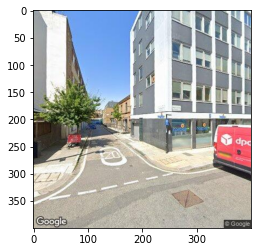

In [46]:
import PIL.Image as pil
img = pil.open(filename).convert('RGB')

from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

In [47]:
original_width, original_height = img.size
feed_height = 192
feed_width = 640

img = img.resize((feed_width, feed_height), pil.LANCZOS)
img = transforms.ToTensor()(mx.nd.array(img)).expand_dims(0).as_in_context(context=ctx)

/tmp/ipykernel_153/3791877393.py:5: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((feed_width, feed_height), pil.LANCZOS)


In [48]:
model = gluoncv.model_zoo.get_model('monodepth2_resnet18_kitti_stereo_640x192',
                                    pretrained_base=False, ctx=ctx, pretrained=True)

In [49]:
outputs = model.predict(img)
disp = outputs[("disp", 0)]
disp_resized = mx.nd.contrib.BilinearResize2D(disp, height=original_height, width=original_width)

In [50]:
import matplotlib as mpl
import matplotlib.cm as cm

In [51]:
disp_resized_np = disp_resized.squeeze().as_in_context(mx.cpu()).asnumpy()
# here the original depth is presented in mm 
# so 1000 should be a proper way to do
disp_resized_np= np.array(disp_resized_np*1000, dtype=np.uint8)

In [52]:
disp_resized_np

array([[ 4,  3,  6, ..., 15, 15, 15],
       [ 4,  3,  6, ..., 15, 15, 15],
       [ 4,  3,  6, ..., 15, 15, 15],
       ...,
       [ 4,  3,  7, ...,  8,  4,  4],
       [ 4,  3,  7, ...,  8,  4,  4],
       [ 4,  3,  7, ...,  8,  4,  4]], dtype=uint8)

In [53]:
 iio.imwrite('../Project-demo/sample_data/depth_predict_1.png', disp_resized_np)

In [54]:
def compute_pcd_vectorization(depth_im):
    """
    This function use victorization operations to optimize time.
    We can do better by computing constants first.
    Please see the main function.
    :param depth_im: a depth image
    :return: the computed point cloud
    """
    # get depth resolution:
    height, width = depth_im.shape
    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)
    # rechape depth image
    z = depth_im.reshape(height * width)
    # compute pcd:
    pcd = np.dstack([(ii - CX_DEPTH) * z / FX_DEPTH,
                    (jj - CY_DEPTH) * z / FY_DEPTH,
                    z]).reshape((length, 3))
    return pcd

Image resolution: (400, 400)
Data type: uint8
Min value: 2
Max value: 89


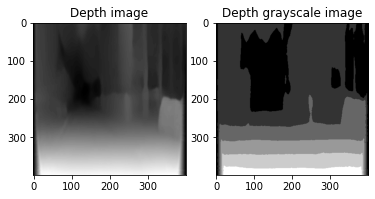

In [55]:
if __name__ == '__main__':
    # Camera parameters:
    FX_DEPTH = 5.8262448167737955e+02
    FY_DEPTH = 5.8269103270988637e+02
    CX_DEPTH = 3.1304475870804731e+02
    CY_DEPTH = 2.3844389626620386e+02

    # Read depth image:
    # ../data/depth.png
    depth_image = iio.imread('../Project-demo/sample_data/depth_predict_1.png')

    # print some properties:
    print(f"Image resolution: {depth_image.shape}")
    print(f"Data type: {depth_image.dtype}")
    print(f"Min value: {np.min(depth_image)}")
    print(f"Max value: {np.max(depth_image)}")

    # Compute depth grayscale:
    depth_grayscale = np.array(256 * depth_image / 0x0fff, dtype=np.uint8)
    iio.imwrite('../Project-demo/sample_data/depth_gray_scale.png', depth_grayscale)

    # Display depth and grayscale image:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(depth_image, cmap="gray")
    axs[0].set_title('Depth image')
    axs[1].imshow(depth_grayscale, cmap="gray")
    axs[1].set_title('Depth grayscale image')
    plt.show()

    # get depth image resolution:
    height, width = depth_image.shape
    
    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)
    # Compute constants:
    xx = (jj - CX_DEPTH) / FX_DEPTH
    yy = (ii - CY_DEPTH) / FY_DEPTH
    # transform depth image to vector of z:
    length = height * width
    
    z = depth_image.reshape(length)
    
    # compute point cloud
    pcd = np.dstack((xx * z, yy * z, z)).reshape((length, 3))

    ## Convert to Open3D.PointCLoud:
    #pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
   # pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
    ## Visualize:
    #o3d.visualization.draw_geometries([pcd_o3d])

In [56]:
pcd.shape

(160000, 3)

In [57]:
pcd

array([[-2.14920429, -1.63684617,  4.        ],
       [-1.6067541 , -1.22763463,  3.        ],
       [-3.20320998, -2.45526925,  6.        ],
       ...,
       [ 1.152787  ,  2.20433945,  8.        ],
       [ 0.58325899,  1.10216972,  4.        ],
       [ 0.59012447,  1.10216972,  4.        ]])

In [58]:
with open('../Project-demo/sample_data/test.npy', 'wb') as f:
    np.save(f, pcd)


In [59]:
with open('../Project-demo/sample_data/test.npy', 'rb') as f:
    a = np.load(f)
print(a)

[[-2.14920429 -1.63684617  4.        ]
 [-1.6067541  -1.22763463  3.        ]
 [-3.20320998 -2.45526925  6.        ]
 ...
 [ 1.152787    2.20433945  8.        ]
 [ 0.58325899  1.10216972  4.        ]
 [ 0.59012447  1.10216972  4.        ]]


In [60]:
def compute_colored_pointcloud_nested_loops(depth_image, rgb_image):
    """
    Compute the colored point cloud using nested loops.
    This function is written for demonstration purposes.
    It takes time.
    :param depth_image: a depth image
    :param rgb_image: the corresponding rgb image
    :return: the colored point cloud
    """

    height, width = depth_image.shape
    colors = []
    pcd = []
    for i in range(height):
        for j in range(width):
            """
                Convert the pixel from depth coordinate system
                to depth sensor 3D coordinate system
            """
            z = depth_image[i][j]
            x = (j - CX_DEPTH) * z / FX_DEPTH
            y = (i - CY_DEPTH) * z / FY_DEPTH

            """
                Convert the point from depth sensor 3D coordinate system
                to rgb camera coordinate system:            
            """
            [x_RGB, y_RGB, z_RGB] = np.linalg.inv(R).dot([x, y, z]) - np.linalg.inv(R).dot(T)

            """
                Convert from rgb camera coordinate system
                to rgb image coordinate system:            
            """
            j_rgb = int((x_RGB * FX_RGB) / z_RGB + CX_RGB + width / 2)
            i_rgb = int((y_RGB * FY_RGB) / z_RGB + CY_RGB)

            # Add point to point cloud:
            pcd.append([x, y, z])

            # Add the color of the pixel if it exists:
            if 0 <= j_rgb < width and 0 <= i_rgb < height:
                colors.append(rgb_image[i_rgb][j_rgb])
            else:
                colors.append([0., 0., 0.])
    return [np.array(pcd), np.array(colors)]

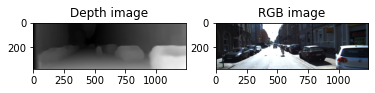

In [61]:
if __name__ == '__main__':
    # Depth Camera parameters:
    FX_DEPTH = 5.8262448167737955e+02
    FY_DEPTH = 5.8269103270988637e+02
    CX_DEPTH = 3.1304475870804731e+02
    CY_DEPTH = 2.3844389626620386e+02

    # RGB camera intrinsic Parameters:
    FX_RGB = 5.1885790117450188e+02
    FY_RGB = 5.1946961112127485e+02
    CX_RGB = 3.2558244941119034e+0
    CY_RGB = 2.5373616633400465e+02

    # Rotation matrix:
    R = -np.array([[9.9997798940829263e-01, 5.0518419386157446e-03, 4.3011152014118693e-03],
                   [-5.0359919480810989e-03, 9.9998051861143999e-01, -3.6879781309514218e-03],
                   [- 4.3196624923060242e-03, 3.6662365748484798e-03, 9.9998394948385538e-01]])
    # Translation vector:
    T = np.array([2.5031875059141302e-02, -2.9342312935846411e-04, 6.6238747008330102e-04])

    # Read depth and color image:
    depth_image = iio.imread('../Project-demo/sample_data/depth_predict.png')
    rgb_image = iio.imread('../Project-demo/sample_data/test_img.png')

    # Display depth and grayscale image:
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(depth_image, cmap="gray")
    axs[0].set_title('Depth image')
    axs[1].imshow(rgb_image)
    axs[1].set_title('RGB image')
    plt.show()

    # compute point cloud:
    # Both images has the same resolution
    height, width = depth_image.shape

    # compute indices:
    jj = np.tile(range(width), height)
    ii = np.repeat(range(height), width)

    # Compute constants:
    xx = (jj - CX_DEPTH) / FX_DEPTH
    yy = (ii - CY_DEPTH) / FY_DEPTH

    # transform depth image to vector of z:
    length = height * width
    z = depth_image.reshape(length)

    # compute point cloud
    pcd = np.dstack((xx * z, yy * z, z)).reshape((length, 3))
    cam_RGB = np.apply_along_axis(np.linalg.inv(R).dot, 1, pcd) - np.linalg.inv(R).dot(T)
    xx_rgb = ((cam_RGB[:, 0] * FX_RGB) / cam_RGB[:, 2] + CX_RGB + width / 2).astype(int).clip(0, width - 1)
    yy_rgb = ((cam_RGB[:, 1] * FY_RGB) / cam_RGB[:, 2] + CY_RGB).astype(int).clip(0, height - 1)
    colors = rgb_image[yy_rgb, xx_rgb]



In [62]:
with open('../Project-demo/sample_data/test_2_pcd.npy', 'wb') as f:
    np.save(f, pcd)

with open('../Project-demo/sample_data/test_2_colors.npy', 'wb') as f:
    np.save(f, colors)

In [63]:
import requests

app_access_token = 'MLY|8443722902364390|832fa01211e391f5fd88c8a6186d2ff8' # create your access token at https://mapillary.com/developer
image_id = '169979785061521'
url = 'https://graph.mapillary.com/{}/?fields=id,camera_parameters,atomic_scale,thumb_original_url&access_token={}'.format(image_id,app_access_token)
# or instead of adding it to the url, add the token in headers (strongly recommended for user tokens)
headers = { "Authorization" : "OAuth {}".format(app_access_token) }
response = requests.get(url, headers)
data = response.json()

print(data)

{'id': '169979785061521', 'camera_parameters': [0.58551074610826, 0.0044488907520614, -0.032349286690073], 'atomic_scale': 1.2171837490563, 'thumb_original_url': 'https://scontent-xsp1-3.xx.fbcdn.net/m1/v/t6/An-lrUC2b2RsLVg4POu8hjHAUCiLVNI9aV08B7WKFuP3HaFvZB6yVxY3hIDsVyIPK5AxN2-T0I65K2ND_ILHn4eVnmrW4oXhQcm3UCOaPEWRnlI5HiUkHsOSWkVqMHC8bb-MaRhsENxYMnxlO2ozLA?ccb=10-5&oh=00_AfCwM6C-vFypAuirb8sX2u195HaU332Fxavr-i8fHEdG7w&oe=640309CF&_nc_sid=122ab1'}


In [64]:
url = data['thumb_original_url']
filename = '../Project-demo/sample_data/test_img_2.png'
gluoncv.utils.download(url, filename, True)

100%|██████████| 1383/1383 [00:00<00:00, 2663.24KB/s]


'../Project-demo/sample_data/test_img_2.png'

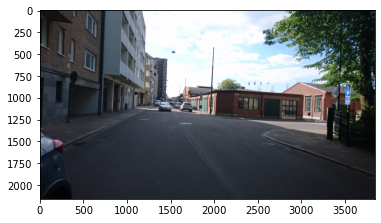

In [65]:
import PIL.Image as pil
img = pil.open(filename).convert('RGB')
iio.imwrite('../Project-demo/sample_data/test_img_2.jpg', img)
from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

In [66]:
original_width, original_height = img.size
feed_height = 192
feed_width = 640

img = img.resize((feed_width, feed_height), pil.LANCZOS)
img = transforms.ToTensor()(mx.nd.array(img)).expand_dims(0).as_in_context(context=ctx)

/tmp/ipykernel_153/3791877393.py:5: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((feed_width, feed_height), pil.LANCZOS)


In [67]:
model = gluoncv.model_zoo.get_model('monodepth2_resnet18_kitti_stereo_640x192',
                                    pretrained_base=False, ctx=ctx, pretrained=True)

In [68]:
outputs = model.predict(img)
disp = outputs[("disp", 0)]
disp_resized = mx.nd.contrib.BilinearResize2D(disp, height=original_height, width=original_width)

In [69]:
import matplotlib as mpl
import matplotlib.cm as cm

In [70]:
disp_resized_np = disp_resized.squeeze().as_in_context(mx.cpu()).asnumpy()
# here the original depth is presented in mm 
# so 1000 should be a proper way to do
disp_resized_np= np.array(disp_resized_np*1000, dtype=np.uint8)

In [71]:
disp_resized_np

array([[ 19,  18,  18, ...,  14,  14,  15],
       [ 19,  18,  18, ...,  14,  14,  15],
       [ 19,  18,  18, ...,  14,  14,  14],
       ...,
       [174, 174, 174, ...,   3,   4,   4],
       [174, 174, 174, ...,   3,   4,   4],
       [174, 174, 174, ...,   3,   4,   4]], dtype=uint8)

In [72]:
iio.imwrite('../Project-demo/sample_data/depth_predict_2.png', disp_resized_np)


In [73]:

filename = '../Project-demo/sample_data/test_img_3.jpg'


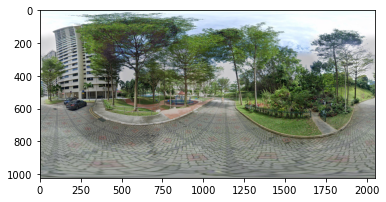

In [74]:
import PIL.Image as pil
img = pil.open(filename).convert('RGB')

from matplotlib import pyplot as plt
plt.imshow(img)
plt.show()

In [75]:
original_width, original_height = img.size
feed_height = 192
feed_width = 640

img = img.resize((feed_width, feed_height), pil.LANCZOS)
img = transforms.ToTensor()(mx.nd.array(img)).expand_dims(0).as_in_context(context=ctx)

/tmp/ipykernel_153/3791877393.py:5: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  img = img.resize((feed_width, feed_height), pil.LANCZOS)


In [76]:
model = gluoncv.model_zoo.get_model('monodepth2_resnet18_kitti_stereo_640x192',
                                    pretrained_base=False, ctx=ctx, pretrained=True)

In [77]:
outputs = model.predict(img)
disp = outputs[("disp", 0)]
disp_resized = mx.nd.contrib.BilinearResize2D(disp, height=original_height, width=original_width)

In [78]:
import matplotlib as mpl
import matplotlib.cm as cm

In [79]:
disp_resized_np = disp_resized.squeeze().as_in_context(mx.cpu()).asnumpy()
# here the original depth is presented in mm 
# so 1000 should be a proper way to do
disp_resized_np= np.array(disp_resized_np*1000, dtype=np.uint8)

In [80]:
disp_resized_np

array([[ 5,  4,  3, ..., 34, 34, 34],
       [ 5,  4,  3, ..., 34, 34, 34],
       [ 5,  4,  3, ..., 35, 34, 34],
       ...,
       [ 5,  4,  3, ..., 90, 90, 90],
       [ 5,  4,  3, ..., 90, 90, 90],
       [ 5,  4,  3, ..., 90, 90, 90]], dtype=uint8)

In [81]:
 iio.imwrite('../Project-demo/sample_data/depth_predict_3.png', disp_resized_np)